# Using single-molecule reactions

This short post was inspired by a recent question on the RDKit-discuss mailing list: https://www.mail-archive.com/rdkit-discuss@lists.sourceforge.net/msg10905.html

The idea is to provide a quick introduction to a piece of chemical reaction functionality which was added to the 2021.09 RDKit release.


In [1]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import rdkit
print(rdkit.__version__)

2021.09.3


This was the molecule that Lewis asked about.

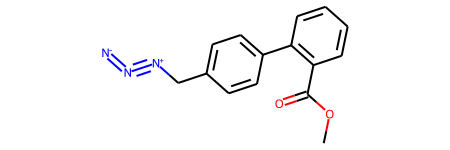

In [2]:
m1 = Chem.MolFromSmiles('COC(=O)C1=C(C=CC=C1)C1=CC=C(C[N+]#[N]=[N-])C=C1',sanitize=False)
m1

The RDKit won't accept this with default settings because there's an odd representation of an azide group which includes a five-valent neutral nitrogen.

It's straight forward to define a reaction which can convert this odd azide form to the more normal variant:

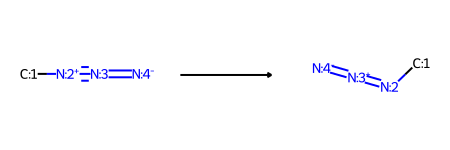

In [3]:
tf1 = rdChemReactions.ReactionFromSmarts('[#6:1]-[N+:2]#[N:3]=[N-:4]>>[#6:1]-[N+0:2]=[N+1:3]=[N-:4]')
tf1

The usual way to use this would be with the `RunReactants()` method, which returns a list of lists of new molecules. In this case though, we have a reaction which operates on a single reactant and has a single product, so we can take advantage of the new `RunReactantInPlace()` method.

As the method name implies, this modifies the reactant molecule in place instead of creating new molecules which are returned as products:

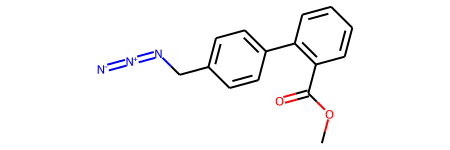

In [4]:
tf1.RunReactantInPlace(m1)

# now sanitize the molecule so that we do chemistry perception and can get decent drawings:
Chem.SanitizeMol(m1)
m1

It's important to note that his only modifies one match at a time, so if we have multiple functional groups which need to be modified, we'll need to call `RunReactantInPlace()` multiple times.

Here's a demonstration of that using a molecule which has two of these weird azide constructions

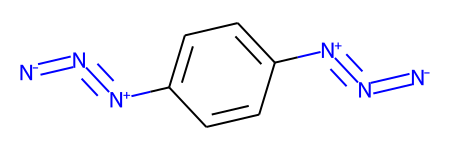

In [5]:
m1 = Chem.MolFromSmiles('c1cc([N+]#[N]=[N-])ccc1[N+]#[N]=[N-]',sanitize=False)
m1

The first application of `RunReactantInPlace()` changes one of the groups:

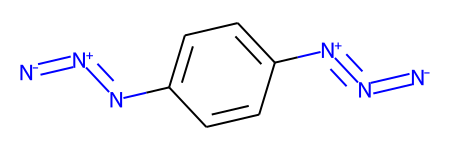

In [6]:
tf1.RunReactantInPlace(m1)
m1

If we call `RunReactantInPlace()` again, the second occurance is replaced:

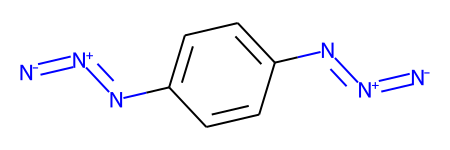

In [7]:
tf1.RunReactantInPlace(m1)
m1

`RunReactantInPlace()` makes it easy to know when to stop because it returns a boolean letting you know whether or not the molecule was modified. So in this case we'll get false:

In [8]:
tf1.RunReactantInPlace(m1)

False

This makes it easy to do all the transformations to a molecule with a while loop:

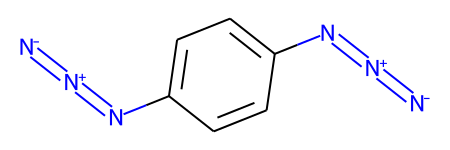

In [9]:
m1 = Chem.MolFromSmiles('c1cc([N+]#[N]=[N-])ccc1[N+]#[N]=[N-]',sanitize=False)
while tf1.RunReactantInPlace(m1):
    pass
Chem.SanitizeMol(m1)
m1

`RunReactantInPlace()` is limited, it can only be used with reactions which only have one reactant and product and which do not add atoms in the product.

In [10]:
tf2 = rdChemReactions.ReactionFromSmarts('[#6:1]-[NH2:2]>>[#6:1]-[NH2:2]C')
tmp = Chem.MolFromSmiles('CCN')
tf2.RunReactantInPlace(tmp)

ValueError: ChemicalParserException: single component reactions which add atoms in the product are not supported

Note that it can be used with reactions which remove atoms:

In [11]:
tf2 = rdChemReactions.ReactionFromSmarts('[#6:1]-[NH2:2]>>[#6:1]')
tmp = Chem.MolFromSmiles('CCN')
tf2.RunReactantInPlace(tmp)

True

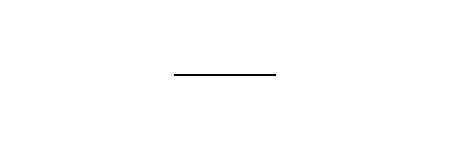

In [12]:
tmp

Aside from being easier to use when working with this simple transformations, it's worth pointing out that `RunReactantInPlace()` is significantly faster than using `RunReactants()` with the same reaction:

In [13]:
m1 = Chem.MolFromSmiles('COC(=O)C1=C(C=CC=C1)C1=CC=C(C[N+]#[N]=[N-])C=C1',sanitize=False)
%timeit tf1.RunReactantInPlace(Chem.Mol(m1))

9.93 µs ± 125 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
m1 = Chem.MolFromSmiles('COC(=O)C1=C(C=CC=C1)C1=CC=C(C[N+]#[N]=[N-])C=C1',sanitize=False)
%timeit tf1.RunReactants((Chem.Mol(m1),))

22.6 µs ± 81.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
